# Guided Backpropagation and Guided Grad-CAM

In [146]:
#!pip3 install torch torchvision

In [5]:
#!pip install captum

In [26]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2022-05-30 23:15:55--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-05-30 23:15:55 (107 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [17]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3',
                       pretrained=True)
model.eval()

Using cache found in /home/jupyter/.cache/torch/hub/pytorch_vision_v0.10.0


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [127]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

def LoadImage(file_path, model='VGG'):
    im = PIL.Image.open(file_path)
    if model == 'Inception':
        im = im.resize((299,299))
    else: 
        im = im.resize((224,224))
    im = np.asarray(im)
    return im

def PreprocessVGGImage(im):
    im = tf.keras.applications.vgg16.preprocess_input(im)
    return im

def PreprocessInceptionImage(im):
    im = tf.keras.applications.inception_v3.preprocess_input(im)
    return im

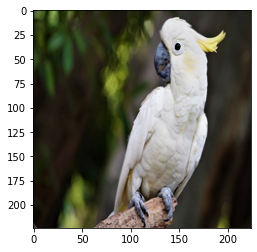

In [128]:
# Load the image
im_orig = LoadImage('./images/cockatoo.jpeg')

plt.imshow(im_orig)
plt.show()

In [129]:
from torchvision import transforms
input_image = PIL.Image.open('./images/cockatoo.jpeg')

In [130]:
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [131]:
input_tensor = preprocess(input_image)
input_tensor = torch.Tensor(input_tensor)
input_batch = input_tensor.unsqueeze(0)

In [132]:
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
# print(probabilities)

In [133]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
    
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

sulphur-crested cockatoo 0.8870694637298584
African grey 0.0019789428915828466
ptarmigan 0.0019761640578508377
macaw 0.0008834960171952844
American chameleon 0.0008563774172216654


## DeConvNet

In [135]:
from captum.attr import Deconvolution

deconv = Deconvolution(model)

In [139]:
deconv_attribution = deconv.attribute(input_batch, target=89)

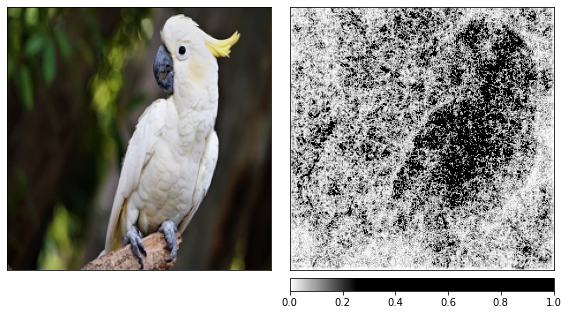

In [140]:
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr_multiple(np.transpose(deconv_attribution.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      im_orig,
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

## Guided Backprop

In [141]:
from captum.attr import GuidedBackprop

gbp = GuidedBackprop(model)

In [143]:
input_batch.requires_grad=True

In [144]:
gbp_attribution = gbp.attribute(input_batch, target=top5_catid[0])

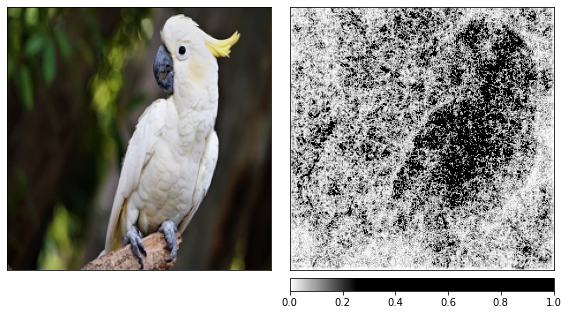

In [145]:
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr_multiple(np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      im_orig,
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

## Guided Grad-CAM

In [123]:
from captum.attr import GuidedGradCam

guided_gc = GuidedGradCam(model, model.Mixed_7c)
attribution = guided_gc.attribute(input_batch, target=top5_catid[0])

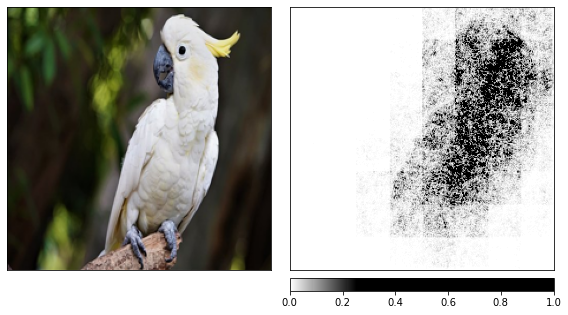

In [125]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr_multiple(np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      im_orig,
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License